In [2]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback

torch.cuda.set_device(0) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df

In [3]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

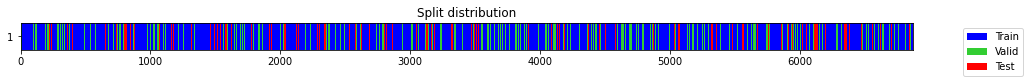

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [4]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

# Multi Label Problem

In [5]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


# Study 1

In [ ]:
# def objective(trial:optuna.Trial):
    
#     # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
#     depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
#     batch_tfms = TSStandardize(by_sample=True)
#     tfms  = [None, TSMultiLabelClassification()]
#     batch_tfms = [TSStandardize(by_sample=True)]
#     dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
#     metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

#     model = InceptionTimePlus(dls.vars, dls.c, dls.len,nf=nf, fc_dropout=dropout_rate, depth=depth)
#     learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


# #     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
#     learn.fit_one_cycle(100, lr_max=learning_rate)

#     # Return the objective value
#     return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

# study_name = "inception" # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=50),sampler=optuna.samplers.RandomSampler())

# study.optimize(objective, n_trials=100)

[I 2022-03-04 19:30:03,026] Using an existing study with name 'inception' instead of creating a new one.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.589244,0.536978,0.790061,0.503044,0.124174,0.126341,0.879747,0.125153,00:20
1,0.526914,0.488515,0.870869,0.527216,0.321746,0.076171,0.978260,0.122369,00:09
2,0.472220,0.441388,0.896485,0.580526,0.830922,0.165824,0.995228,0.275183,00:09
3,0.419493,0.384687,0.901495,0.592153,0.931556,0.186142,0.998164,0.309403,00:09
4,0.365663,0.333679,0.904727,0.607553,0.925572,0.217492,0.997614,0.350797,00:09
5,0.316953,0.287267,0.907313,0.623119,0.895839,0.250092,0.996146,0.390053,00:10
6,0.279729,0.259911,0.909980,0.648436,0.834081,0.305130,0.991742,0.446016,00:09
7,0.252532,0.238146,0.915717,0.667619,0.872595,0.341932,0.993305,0.489596,00:09
8,0.230621,0.221574,0.920081,0.690026,0.867967,0.388033,0.992019,0.534514,00:09
9,0.215019,0.208594,0.921697,0.702796,0.852397,0.415405,0.990187,0.556948,00:09


[I 2022-03-04 19:47:22,978] Trial 2 finished with value: 0.7677621841430664 and parameters: {'num_filters': 16, 'depth': 9, 'dropout_rate': 0.0, 'learning_rate': 0.0008708423116718709}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.613365,0.567320,0.838465,0.638070,0.338692,0.375010,0.901129,0.355681,00:06
1,0.546415,0.498463,0.888727,0.641943,0.559515,0.317997,0.965889,0.403749,00:06
2,0.482857,0.438409,0.900364,0.620830,0.737333,0.253949,0.987711,0.376752,00:06
3,0.420613,0.372058,0.902141,0.608572,0.834112,0.223289,0.993855,0.350937,00:06
4,0.361149,0.319826,0.904970,0.613422,0.891017,0.230788,0.996056,0.365186,00:06
5,0.316718,0.286816,0.904323,0.606717,0.917990,0.216097,0.997337,0.348512,00:06
6,0.283399,0.261279,0.908848,0.632409,0.885046,0.269592,0.995227,0.411941,00:06
7,0.262126,0.244579,0.910222,0.637853,0.889225,0.280387,0.995320,0.425224,00:06
8,0.246864,0.236710,0.911434,0.659274,0.819264,0.328276,0.990272,0.467707,00:06
9,0.232129,0.225718,0.915071,0.676221,0.825753,0.362718,0.989724,0.502604,00:06


[I 2022-03-04 19:59:05,943] Trial 4 finished with value: 0.7637763023376465 and parameters: {'num_filters': 16, 'depth': 6, 'dropout_rate': 0.2, 'learning_rate': 0.0012077565257271456}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.667117,0.637964,0.739636,0.475867,0.089324,0.129677,0.822058,0.105696,00:09
1,0.617484,0.582985,0.862788,0.529356,0.273538,0.091729,0.966984,0.137155,00:08
2,0.569012,0.534712,0.891556,0.560033,0.780487,0.124922,0.995143,0.214270,00:08
3,0.522991,0.489894,0.896404,0.574806,0.871525,0.152727,0.996884,0.258988,00:08
4,0.479426,0.445243,0.899636,0.587521,0.896028,0.177882,0.997159,0.295944,00:09
5,0.437098,0.403313,0.900525,0.591298,0.899541,0.185438,0.997157,0.306714,00:08
6,0.399172,0.367139,0.900525,0.589232,0.918501,0.180665,0.997799,0.300901,00:08
7,0.363290,0.332621,0.900929,0.591799,0.909957,0.186074,0.997524,0.308523,00:08
8,0.331866,0.310812,0.899475,0.584551,0.914700,0.171212,0.997890,0.287560,00:08
9,0.306381,0.287102,0.903030,0.604745,0.885019,0.213252,0.996237,0.342604,00:09


[I 2022-03-04 20:14:26,707] Trial 5 finished with value: 0.7387648224830627 and parameters: {'num_filters': 40, 'depth': 3, 'dropout_rate': 0.2, 'learning_rate': 0.0002134641158700417}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.615948,0.594997,0.798949,0.625967,0.267899,0.398893,0.853042,0.320455,00:17
1,0.582185,0.552340,0.848000,0.644651,0.365985,0.377730,0.911572,0.371488,00:17
2,0.546419,0.514937,0.887515,0.640328,0.548017,0.315877,0.964780,0.400173,00:17
3,0.510792,0.481030,0.896727,0.626795,0.662157,0.272484,0.981106,0.385259,00:17
4,0.476505,0.447951,0.900525,0.622234,0.736716,0.256943,0.987525,0.380102,00:17
5,0.443019,0.416162,0.901818,0.616401,0.786084,0.241789,0.991012,0.368801,00:17
6,0.412932,0.385781,0.902788,0.615161,0.817299,0.237660,0.992661,0.367115,00:17
7,0.383391,0.358100,0.904808,0.624310,0.825206,0.256142,0.992478,0.389317,00:17
8,0.355634,0.334922,0.906263,0.632707,0.819227,0.273671,0.991743,0.408904,00:17
9,0.329707,0.310009,0.908040,0.634889,0.851991,0.276384,0.993393,0.415382,00:17


[I 2022-03-04 20:44:30,858] Trial 6 finished with value: 0.7408456206321716 and parameters: {'num_filters': 40, 'depth': 6, 'dropout_rate': 0.30000000000000004, 'learning_rate': 7.746150472987174e-05}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.707148,0.699020,0.525333,0.535337,0.134246,0.548480,0.522194,0.215678,00:05
1,0.704387,0.695288,0.535434,0.536968,0.135370,0.538996,0.534941,0.216375,00:04
2,0.700256,0.690233,0.550707,0.540409,0.137598,0.526889,0.553929,0.218189,00:04
3,0.694223,0.683890,0.566707,0.542124,0.139291,0.509860,0.574388,0.218784,00:04
4,0.686807,0.675668,0.595071,0.553248,0.146588,0.498351,0.608144,0.226508,00:04
5,0.676998,0.665588,0.618101,0.558961,0.151660,0.481347,0.636576,0.230621,00:04
6,0.668486,0.653906,0.634263,0.561390,0.154931,0.465749,0.657032,0.232487,00:04
7,0.656823,0.641090,0.672646,0.569436,0.165577,0.433963,0.704910,0.239656,00:04
8,0.642519,0.627393,0.721212,0.578212,0.183584,0.390519,0.765904,0.249712,00:04
9,0.629193,0.612946,0.776242,0.587181,0.217065,0.339017,0.835346,0.264566,00:04


[I 2022-03-04 20:53:09,426] Trial 7 finished with value: 0.34775108098983765 and parameters: {'num_filters': 24, 'depth': 3, 'dropout_rate': 0.4, 'learning_rate': 1.4531229711345017e-05}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.497504,0.417324,0.897939,0.580101,0.892520,0.162954,0.997249,0.274594,00:05
1,0.392176,0.329015,0.899798,0.587894,0.901372,0.178541,0.997247,0.297046,00:05
2,0.329348,0.287444,0.900687,0.589362,0.923202,0.180745,0.997980,0.301403,00:05
3,0.291517,0.266540,0.901495,0.593046,0.923391,0.188202,0.997890,0.311841,00:06
4,0.270570,0.249970,0.905455,0.616722,0.882493,0.237758,0.995687,0.373342,00:05
5,0.257318,0.243207,0.910626,0.649330,0.844304,0.306367,0.992293,0.448826,00:05
6,0.243754,0.235708,0.911030,0.651363,0.844326,0.310520,0.992206,0.452896,00:05
7,0.236167,0.222211,0.916687,0.669555,0.885676,0.345167,0.993943,0.495532,00:05
8,0.225954,0.216520,0.919030,0.693477,0.838033,0.397412,0.989543,0.537875,00:05
9,0.219759,0.211390,0.917737,0.692184,0.818401,0.396110,0.988258,0.532491,00:05


[I 2022-03-04 21:03:28,988] Trial 8 finished with value: 0.7520022392272949 and parameters: {'num_filters': 32, 'depth': 3, 'dropout_rate': 0.5, 'learning_rate': 0.003150330994599211}. Best is trial 2 with value: 0.7677621841430664.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.438510,0.350951,0.898424,0.579466,0.920902,0.160860,0.998072,0.273057,00:09
1,0.335602,0.273772,0.905374,0.617208,0.875432,0.239004,0.995412,0.374255,00:09
2,0.279826,0.240074,0.911111,0.643959,0.880158,0.293332,0.994585,0.438705,00:09
3,0.251242,0.221762,0.916525,0.671906,0.871496,0.350784,0.993028,0.498413,00:10
4,0.230400,0.222767,0.917333,0.712151,0.762400,0.442832,0.981470,0.559559,00:09
5,0.221074,0.204904,0.921697,0.704151,0.846898,0.418579,0.989723,0.558966,00:09
6,0.213309,0.221214,0.920000,0.700166,0.831470,0.411614,0.988718,0.549828,00:09
7,0.200058,0.194118,0.929697,0.745830,0.841316,0.504501,0.987160,0.630341,00:09
8,0.194497,0.203546,0.925737,0.752475,0.779911,0.525038,0.979913,0.626887,00:09
9,0.186950,0.212205,0.924444,0.737750,0.795234,0.492748,0.982752,0.607954,00:09


[I 2022-03-04 21:20:21,895] Trial 9 finished with value: 0.7681387662887573 and parameters: {'num_filters': 24, 'depth': 6, 'dropout_rate': 0.5, 'learning_rate': 0.006266436975354607}. Best is trial 9 with value: 0.7681387662887573.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.662646,0.656080,0.600808,0.431305,0.075425,0.208877,0.653733,0.110818,00:04
1,0.654656,0.645174,0.624566,0.443927,0.080517,0.206879,0.680975,0.115904,00:04
2,0.644788,0.632648,0.667152,0.465832,0.091640,0.201611,0.730054,0.125975,00:04
3,0.631110,0.617333,0.730828,0.485336,0.102494,0.163116,0.807557,0.125816,00:04
4,0.615897,0.600158,0.772525,0.506037,0.127624,0.156270,0.855805,0.140444,00:04
5,0.597868,0.579951,0.792889,0.518124,0.149052,0.157510,0.878738,0.153117,00:04
6,0.578620,0.559111,0.800404,0.525704,0.163364,0.165151,0.886258,0.164203,00:04
7,0.558329,0.536877,0.822141,0.548847,0.217061,0.190156,0.907537,0.202580,00:04
8,0.535853,0.513891,0.853818,0.558937,0.300364,0.171911,0.945962,0.218302,00:04
9,0.514152,0.489934,0.880727,0.569789,0.499138,0.161688,0.977891,0.243794,00:04


[I 2022-03-04 21:29:03,391] Trial 10 finished with value: 0.5604575872421265 and parameters: {'num_filters': 24, 'depth': 3, 'dropout_rate': 0.4, 'learning_rate': 5.574613611335201e-05}. Best is trial 9 with value: 0.7681387662887573.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.431378,0.353029,0.900929,0.596444,0.874489,0.196834,0.996054,0.320623,00:11
1,0.328520,0.278999,0.907071,0.634360,0.831946,0.276430,0.992290,0.414330,00:12
2,0.273244,0.239040,0.912243,0.653241,0.861659,0.313274,0.993207,0.458636,00:11
3,0.242986,0.240772,0.914020,0.691802,0.765469,0.400121,0.983483,0.525094,00:11
4,0.223508,0.221766,0.919919,0.698578,0.835743,0.408076,0.989081,0.547246,00:11
5,0.208931,0.274336,0.892202,0.658242,0.577426,0.351160,0.965324,0.436304,00:11
6,0.196866,0.190282,0.927273,0.745229,0.813211,0.506231,0.984227,0.623164,00:11
7,0.188460,0.178472,0.933980,0.770344,0.834299,0.555541,0.985146,0.666176,00:11
8,0.180300,0.179805,0.935838,0.779263,0.835887,0.573751,0.984775,0.680109,00:11
9,0.176210,0.216728,0.920000,0.741863,0.737266,0.508120,0.975606,0.601092,00:11


[I 2022-03-04 21:49:09,307] Trial 11 finished with value: 0.7775713801383972 and parameters: {'num_filters': 32, 'depth': 6, 'dropout_rate': 0.4, 'learning_rate': 0.003986720385886889}. Best is trial 11 with value: 0.7775713801383972.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.552418,0.490294,0.899556,0.602199,0.793544,0.211916,0.992481,0.333624,00:11
1,0.445842,0.381966,0.901414,0.603271,0.846207,0.211955,0.994586,0.338166,00:11
2,0.364165,0.314616,0.904727,0.614477,0.875145,0.233542,0.995412,0.367827,00:11
3,0.304676,0.271067,0.906990,0.623955,0.883695,0.252498,0.995412,0.391345,00:11
4,0.264193,0.248204,0.911596,0.649766,0.862931,0.306138,0.993393,0.450850,00:11
5,0.235195,0.225099,0.918626,0.691383,0.836085,0.393133,0.989633,0.534227,00:11
6,0.219314,0.222595,0.916364,0.693090,0.797643,0.400029,0.986152,0.531393,00:11
7,0.206063,0.201082,0.926141,0.728129,0.839973,0.468183,0.988076,0.600140,00:11
8,0.192105,0.215698,0.919919,0.723512,0.771685,0.465737,0.981286,0.579681,00:12
9,0.182937,0.186137,0.929939,0.761498,0.808884,0.540333,0.982663,0.646694,00:11


[I 2022-03-04 22:09:18,701] Trial 12 finished with value: 0.7695434093475342 and parameters: {'num_filters': 32, 'depth': 6, 'dropout_rate': 0.1, 'learning_rate': 0.0014573096384656581}. Best is trial 11 with value: 0.7775713801383972.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.359385,0.289833,0.904889,0.617633,0.861176,0.240588,0.994679,0.375269,00:25
1,0.273886,0.234217,0.915798,0.677466,0.833785,0.364564,0.990367,0.506227,00:26
2,0.233410,0.207450,0.923394,0.724220,0.813304,0.462750,0.985689,0.588978,00:26
3,0.208127,0.195517,0.927838,0.745481,0.818890,0.506096,0.984867,0.625143,00:26
4,0.189235,0.185164,0.930909,0.760846,0.819116,0.537649,0.984044,0.648574,00:25
5,0.175186,0.208323,0.927354,0.764561,0.774234,0.550857,0.978266,0.642984,00:25
6,0.171301,0.184248,0.934707,0.768903,0.847016,0.551292,0.986513,0.667398,00:25
7,0.171826,0.234716,0.922747,0.742115,0.766658,0.504965,0.979265,0.608232,00:25
8,0.167173,0.207519,0.923555,0.771349,0.728269,0.571592,0.971107,0.640047,00:25
9,0.160821,0.219472,0.920000,0.750452,0.725334,0.527957,0.972948,0.610781,00:25


[I 2022-03-04 22:53:21,135] Trial 13 finished with value: 0.781830906867981 and parameters: {'num_filters': 40, 'depth': 9, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.003992675587579965}. Best is trial 13 with value: 0.781830906867981.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.625265,0.595170,0.758949,0.504367,0.124433,0.170263,0.838471,0.143701,00:11
1,0.583441,0.545688,0.876525,0.546553,0.434791,0.113462,0.979644,0.179286,00:11
2,0.540270,0.504782,0.895192,0.578618,0.796283,0.163106,0.994129,0.269898,00:11
3,0.499864,0.468977,0.897859,0.584764,0.848938,0.173839,0.995690,0.287816,00:11
4,0.462547,0.432581,0.898828,0.587653,0.864373,0.179251,0.996055,0.295860,00:11
5,0.426831,0.398100,0.900768,0.593152,0.892475,0.189424,0.996881,0.311713,00:11
6,0.391097,0.363064,0.901899,0.599988,0.879515,0.203738,0.996238,0.329884,00:11
7,0.359252,0.332440,0.903838,0.606604,0.898447,0.216512,0.996697,0.347291,00:11
8,0.327914,0.304641,0.906343,0.619383,0.889659,0.242804,0.995963,0.380033,00:11
9,0.300353,0.283249,0.909172,0.633398,0.888940,0.271476,0.995320,0.414395,00:11


[I 2022-03-04 23:13:25,083] Trial 14 finished with value: 0.754647433757782 and parameters: {'num_filters': 32, 'depth': 6, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0001588110825862724}. Best is trial 13 with value: 0.781830906867981.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.627736,0.587219,0.881697,0.615299,0.507863,0.265634,0.964964,0.348118,00:04
1,0.571937,0.527898,0.894788,0.588616,0.731074,0.186769,0.990463,0.296225,00:04
2,0.520591,0.477177,0.896485,0.578092,0.847944,0.160219,0.995964,0.268623,00:04
3,0.470404,0.426005,0.897697,0.579028,0.891719,0.160810,0.997247,0.271667,00:04
4,0.425203,0.380982,0.897859,0.577957,0.910090,0.158118,0.997796,0.268580,00:04
5,0.383626,0.342154,0.898263,0.581142,0.896705,0.164946,0.997338,0.277419,00:04
6,0.347121,0.311653,0.898909,0.581508,0.921988,0.164944,0.998072,0.279000,00:04
7,0.319627,0.292357,0.897939,0.575138,0.942746,0.151468,0.998808,0.260328,00:04
8,0.298807,0.277107,0.901253,0.589974,0.942118,0.181417,0.998531,0.303296,00:04
9,0.282657,0.263418,0.904889,0.613145,0.888228,0.230235,0.996054,0.364765,00:04


[I 2022-03-04 23:22:05,266] Trial 15 finished with value: 0.71662437915802 and parameters: {'num_filters': 24, 'depth': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0006275398983451788}. Best is trial 13 with value: 0.781830906867981.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.410668,0.335827,0.902545,0.611516,0.828200,0.229545,0.993487,0.359033,00:17
1,0.309621,0.266233,0.911030,0.646938,0.866449,0.300301,0.993576,0.445169,00:17
2,0.254136,0.224002,0.916768,0.671539,0.876799,0.349686,0.993393,0.498973,00:17
3,0.219662,0.239140,0.912485,0.676558,0.784328,0.366968,0.986148,0.498500,00:17
4,0.196905,0.197738,0.926141,0.741741,0.805508,0.499710,0.983772,0.616207,00:17
5,0.179750,0.215631,0.919596,0.717439,0.779458,0.452119,0.982759,0.572030,00:17
6,0.174278,0.166144,0.940444,0.787768,0.870385,0.587369,0.988167,0.701252,00:17
7,0.169687,0.194766,0.928404,0.746159,0.821893,0.506989,0.985328,0.626039,00:17
8,0.166666,0.177686,0.935515,0.780831,0.828057,0.577803,0.983860,0.680112,00:17
9,0.165437,0.186139,0.929939,0.750868,0.830417,0.515858,0.985878,0.635846,00:17


[I 2022-03-04 23:52:03,876] Trial 16 finished with value: 0.795535147190094 and parameters: {'num_filters': 32, 'depth': 9, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00379612171332523}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.673477,0.659881,0.573010,0.486258,0.111780,0.372338,0.600177,0.171881,00:08
1,0.659681,0.642434,0.678384,0.517832,0.132434,0.307072,0.728591,0.184959,00:08
2,0.643192,0.623143,0.756202,0.531886,0.155759,0.237482,0.826290,0.187913,00:08
3,0.622782,0.599821,0.812848,0.536432,0.188403,0.173666,0.899197,0.180590,00:08
4,0.598871,0.574064,0.862303,0.544368,0.309340,0.127075,0.961661,0.179381,00:08
5,0.573996,0.546996,0.882586,0.544120,0.535340,0.099888,0.988351,0.167654,00:08
6,0.548024,0.521272,0.891879,0.554938,0.851110,0.112718,0.997157,0.197878,00:08
7,0.521296,0.495196,0.894545,0.564687,0.886058,0.131759,0.997615,0.228468,00:08
8,0.495731,0.467893,0.895838,0.569849,0.896738,0.141992,0.997706,0.244033,00:08
9,0.470253,0.443121,0.897697,0.577046,0.910927,0.156204,0.997889,0.265774,00:08


[I 2022-03-05 00:07:23,868] Trial 17 finished with value: 0.5957931876182556 and parameters: {'num_filters': 40, 'depth': 3, 'dropout_rate': 0.5, 'learning_rate': 4.124664406138553e-05}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.710727,0.683444,0.541818,0.537669,0.136050,0.532224,0.543113,0.216682,00:06
1,0.677454,0.641563,0.568000,0.545199,0.140808,0.515273,0.575125,0.221153,00:06
2,0.640420,0.602125,0.679111,0.579312,0.173074,0.448290,0.710333,0.249672,00:06
3,0.603234,0.563581,0.789737,0.577853,0.219475,0.299719,0.855987,0.253253,00:06
4,0.566511,0.531328,0.836121,0.585022,0.288679,0.255443,0.914602,0.270364,00:06
5,0.531399,0.496524,0.868283,0.586456,0.404038,0.216571,0.956341,0.280808,00:06
6,0.494524,0.454023,0.899071,0.600125,0.795511,0.207769,0.992480,0.328320,00:06
7,0.456906,0.412836,0.901252,0.599902,0.859456,0.204390,0.995413,0.329564,00:06
8,0.417408,0.372654,0.901495,0.597374,0.886085,0.198236,0.996512,0.323488,00:06
9,0.379222,0.341254,0.901980,0.596165,0.914067,0.194808,0.997522,0.320381,00:06


[I 2022-03-05 00:18:59,402] Trial 18 finished with value: 0.7507068514823914 and parameters: {'num_filters': 16, 'depth': 6, 'dropout_rate': 0.5, 'learning_rate': 0.0002913651189111732}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.632170,0.586281,0.804202,0.510931,0.140610,0.126059,0.895802,0.132871,00:08
1,0.561178,0.512013,0.883717,0.568044,0.540303,0.153703,0.982385,0.238770,00:08
2,0.496904,0.448007,0.897859,0.576525,0.928322,0.154793,0.998257,0.264040,00:08
3,0.438698,0.390257,0.898263,0.577665,0.931636,0.156890,0.998440,0.267353,00:08
4,0.382809,0.338945,0.897778,0.573891,0.950252,0.148790,0.998991,0.256235,00:08
5,0.337635,0.303861,0.899798,0.583563,0.942361,0.168503,0.998624,0.285199,00:08
6,0.304412,0.279707,0.900444,0.585985,0.945934,0.173256,0.998715,0.292170,00:08
7,0.282157,0.256953,0.905697,0.617082,0.886159,0.238292,0.995871,0.374602,00:08
8,0.265596,0.248789,0.908283,0.629251,0.888942,0.262998,0.995504,0.404633,00:08
9,0.250732,0.238764,0.909657,0.634658,0.893337,0.273720,0.995596,0.417936,00:08


[I 2022-03-05 00:34:14,512] Trial 19 finished with value: 0.7475379109382629 and parameters: {'num_filters': 40, 'depth': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0005961909826881241}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.696491,0.654654,0.604444,0.607971,0.172583,0.612551,0.603392,0.269227,00:11
1,0.639059,0.597547,0.731071,0.646151,0.229407,0.534645,0.757657,0.320969,00:11
2,0.588998,0.553031,0.851232,0.641287,0.372280,0.365678,0.916897,0.368404,00:11
3,0.543205,0.509079,0.893414,0.628904,0.617071,0.281747,0.976061,0.385545,00:11
4,0.498451,0.467744,0.900687,0.621329,0.744857,0.254674,0.987984,0.378361,00:11
5,0.454229,0.423253,0.900929,0.614959,0.773601,0.239642,0.990276,0.364394,00:11
6,0.410009,0.378193,0.903515,0.618733,0.819379,0.244989,0.992477,0.375502,00:11
7,0.368762,0.338151,0.906747,0.633493,0.826911,0.274876,0.992110,0.411477,00:11
8,0.332871,0.305903,0.909495,0.640599,0.857403,0.287711,0.993487,0.429669,00:11
9,0.300862,0.278938,0.910465,0.643330,0.869673,0.292717,0.993944,0.436913,00:11


[I 2022-03-05 00:54:19,695] Trial 20 finished with value: 0.7460208535194397 and parameters: {'num_filters': 32, 'depth': 6, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00019176259767210278}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.502324,0.435685,0.899152,0.605542,0.770907,0.220163,0.990921,0.341399,00:17
1,0.397306,0.345081,0.904646,0.614531,0.873379,0.233741,0.995321,0.367740,00:17
2,0.323177,0.282587,0.909172,0.635286,0.878966,0.275803,0.994770,0.418549,00:17
3,0.275301,0.244380,0.914828,0.666647,0.857310,0.340909,0.992385,0.486557,00:17
4,0.243848,0.222058,0.919596,0.701179,0.821610,0.414468,0.987890,0.549603,00:17
5,0.220574,0.206147,0.925333,0.714043,0.871399,0.436707,0.991378,0.580668,00:17
6,0.204799,0.207082,0.922343,0.712655,0.829559,0.437416,0.987894,0.571873,00:17
7,0.193282,0.198001,0.924929,0.709315,0.882455,0.426332,0.992297,0.573478,00:17
8,0.179947,0.181478,0.933737,0.769628,0.833659,0.554203,0.985052,0.665527,00:17
9,0.170512,0.182381,0.933010,0.774323,0.814626,0.566069,0.982576,0.667653,00:17


[I 2022-03-05 01:24:21,392] Trial 21 finished with value: 0.7877407670021057 and parameters: {'num_filters': 40, 'depth': 6, 'dropout_rate': 0.2, 'learning_rate': 0.001325852176704881}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.706082,0.701503,0.540202,0.534729,0.134613,0.527540,0.541918,0.214472,00:17
1,0.699698,0.692548,0.552000,0.536995,0.136193,0.517303,0.556686,0.215598,00:17
2,0.691327,0.682486,0.567192,0.542111,0.139343,0.509189,0.575033,0.218783,00:17
3,0.680164,0.669330,0.589818,0.549114,0.144236,0.495673,0.602555,0.223417,00:17
4,0.666382,0.652586,0.623919,0.560825,0.153552,0.478009,0.643640,0.232397,00:17
5,0.649681,0.633413,0.672162,0.596779,0.181284,0.497817,0.695741,0.265717,00:17
6,0.631185,0.613492,0.720404,0.637028,0.219473,0.527499,0.746557,0.309879,00:17
7,0.612022,0.592834,0.759758,0.649716,0.248979,0.505178,0.794253,0.333430,00:17
8,0.593057,0.576251,0.807677,0.659497,0.300793,0.464934,0.854060,0.365124,00:17
9,0.574995,0.558894,0.840404,0.665992,0.359550,0.437008,0.894976,0.394294,00:17


[I 2022-03-05 01:54:17,041] Trial 22 finished with value: 0.6572583317756653 and parameters: {'num_filters': 32, 'depth': 9, 'dropout_rate': 0.0, 'learning_rate': 1.1370386859088766e-05}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.510385,0.445264,0.900121,0.622663,0.727937,0.258535,0.986791,0.380181,00:09
1,0.378687,0.320109,0.903434,0.606106,0.889218,0.215882,0.996329,0.346106,00:09
2,0.299648,0.256043,0.910141,0.644268,0.855171,0.295324,0.993211,0.437957,00:09
3,0.257943,0.241169,0.912646,0.652589,0.873054,0.311232,0.993946,0.457508,00:09
4,0.232633,0.228027,0.914505,0.691201,0.773300,0.398094,0.984309,0.524802,00:09
5,0.213548,0.207727,0.920081,0.701458,0.828182,0.414472,0.988443,0.551183,00:10
6,0.200901,0.191491,0.927111,0.729930,0.849318,0.471140,0.988721,0.605397,00:09
7,0.186827,0.183320,0.933253,0.772422,0.820197,0.561355,0.983490,0.666273,00:09
8,0.178626,0.196341,0.927434,0.760795,0.781350,0.542043,0.979546,0.639649,00:09
9,0.173017,0.194223,0.931071,0.769342,0.804827,0.557023,0.981660,0.657731,00:09


[I 2022-03-05 02:11:12,433] Trial 23 finished with value: 0.7832508087158203 and parameters: {'num_filters': 24, 'depth': 6, 'dropout_rate': 0.1, 'learning_rate': 0.003890970607535239}. Best is trial 16 with value: 0.795535147190094.


epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.418057,0.326834,0.898182,0.576726,0.938622,0.154827,0.998624,0.264787,00:08
1,0.319637,0.276288,0.900929,0.590630,0.921794,0.183369,0.997890,0.305065,00:08
2,0.279559,0.258720,0.903515,0.604777,0.901793,0.212675,0.996880,0.343421,00:08
3,0.256354,0.237192,0.910303,0.637744,0.895011,0.279985,0.995502,0.425254,00:08
4,0.244406,0.231842,0.913616,0.662128,0.852705,0.332057,0.992199,0.475871,00:08
5,0.232583,0.219488,0.915071,0.678842,0.816490,0.368782,0.988903,0.507117,00:08
6,0.225876,0.226088,0.919354,0.693807,0.839372,0.397799,0.989816,0.539062,00:08
7,0.218185,0.245713,0.908929,0.683646,0.717012,0.387935,0.979356,0.502782,00:08
8,0.214714,0.250369,0.909172,0.701111,0.691538,0.427994,0.974229,0.527778,00:08
9,0.209033,0.207366,0.923313,0.725471,0.809260,0.465797,0.985144,0.590620,00:08


In [ ]:
import optuna
import pandas as pd
import numpy as np
import imp  
study = optuna.load_study(study_name='inception', storage='sqlite:///inception.db')
display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))

In [ ]:
InceptionTimePlus(
    c_in,
    c_out,
    seq_len=None,
    nf=32,
    nb_filters=None,
    flatten=False,
    concat_pool=False,
    fc_dropout=0.0,
    bn=False,
    y_range=None,
    custom_head=None,
    ks=40,
    bottleneck=True,
    padding='same',
    coord=False,
    separable=False,
    dilation=1,
    stride=1,
    conv_dropout=0.0,
    sa=False,
    se=None,
    norm='Batch',
    zero_norm=False,
    bn_1st=True,
    act=<class 'torch.nn.modules.activation.ReLU'>,
    act_kwargs={},
)

# study 2

In [ ]:
def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_multilabel_big.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        learn.export(PATH)

In [ ]:
def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
    depth = trial.suggest_int('depth', 12,18,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.3, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len,conv_dropout=conv_dropout, depth=depth)
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(175, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception_study2" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=125),sampler=optuna.samplers.RandomSampler())

study.optimize(objective, n_trials=100,callbacks=[save_callback])

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.709801,0.699512,0.484364,0.431461,0.089244,0.362000,0.500921,0.143169,00:31
1,0.691819,0.680733,0.559192,0.452199,0.093610,0.311757,0.592642,0.143962,00:30
2,0.672967,0.665429,0.607192,0.489800,0.112794,0.335683,0.643917,0.168818,00:31
3,0.654616,0.650922,0.656081,0.539262,0.144916,0.385895,0.692629,0.210648,00:31
4,0.635830,0.633695,0.732525,0.579207,0.188614,0.377906,0.780508,0.251467,00:32
5,0.616195,0.612753,0.820445,0.615869,0.289493,0.347305,0.884433,0.314915,00:32
6,0.596668,0.596177,0.846384,0.619959,0.347630,0.322752,0.917165,0.333087,00:32
7,0.577870,0.582095,0.860849,0.617858,0.394133,0.298916,0.936799,0.337776,00:32
8,0.560818,0.566764,0.874990,0.623164,0.464713,0.292654,0.953675,0.356645,00:32
9,0.545240,0.553200,0.877657,0.623834,0.483501,0.290689,0.956979,0.360250,00:32


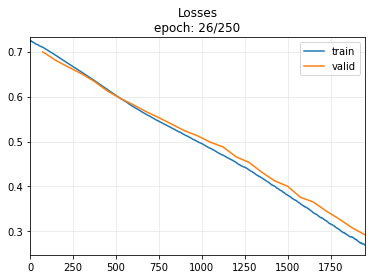

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=0.1, depth=16,)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(250, lr_max=1e-4)
learn.recorder.plot_metrics()

In [24]:
np.array(model(next(iter(dls.train))[0]).detach().cpu())

(64, 9)

In [8]:
PATH = Path('./models/inception_multilabel_defloss.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [25]:
PATH = Path('./models/inception_multilabel.pkl')
learn = load_learner(PATH, cpu=False)

In [26]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

In [1]:
from sklearn.metrics import classification_report
y_pred=np.argmax(valid_preds, axis=1)
y_test=np.argmax(valid_targets, axis=1)

print(classification_report(y_test, y_pred,target_names = df.columns))

NameError: name 'np' is not defined

In [16]:
 y_pred,y_test

(TensorBase([8, 4, 4,  ..., 8, 6, 8]),
 TensorMultiCategory([8, 1, 3,  ..., 4, 8, 8]))